In [43]:
import tensorflow as tf
import tensorflow_docs as tfdocs

tf.__version__

'2.19.0'

In [44]:
import os
from pathlib import Path

tensorbaord_log_dir = Path("logs")
os.mkdir(tensorbaord_log_dir)

FileExistsError: [Errno 17] File exists: 'logs'

In [45]:
# load the data
url = 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz'

dataset_dir = tf.keras.utils.get_file("HIGGS.csv.gz",url)

In [46]:
dataset_dir

'/Users/sachinmurali/.keras/datasets/HIGGS.csv.gz'

In [47]:
# uncompress the gz file get the csv
FEATURES = 28
ds = tf.data.experimental.CsvDataset(dataset_dir,[float(),]*(FEATURES+1), compression_type="GZIP")


In [48]:
next(iter(ds.batch(1)))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8692932], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6350818], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.22569026], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.32747006], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6899932], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.75420225], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.24857314], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.0920639], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.3749921], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6536742], dtype=float32)>,
 <tf.Tensor: shape=(1

In [49]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], axis=1)
    return features, label

In [50]:
packed_ds = ds.batch(32).map(pack_row).unbatch()

In [51]:
next(iter(packed_ds))

(<tf.Tensor: shape=(28,), dtype=float32, numpy=
 array([ 0.8692932 , -0.6350818 ,  0.22569026,  0.32747006, -0.6899932 ,
         0.75420225, -0.24857314, -1.0920639 ,  0.        ,  1.3749921 ,
        -0.6536742 ,  0.9303491 ,  1.1074361 ,  1.1389043 , -1.5781983 ,
        -1.0469854 ,  0.        ,  0.65792954, -0.01045457, -0.04576717,
         3.1019614 ,  1.35376   ,  0.9795631 ,  0.97807616,  0.92000484,
         0.72165745,  0.98875093,  0.87667835], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [52]:
N_VALIDATION  = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE  # 20

In [53]:

validation_ds = packed_ds.take(N_VALIDATION).cache().batch(BATCH_SIZE)
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [54]:
# learning aret schdeuler
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

[]

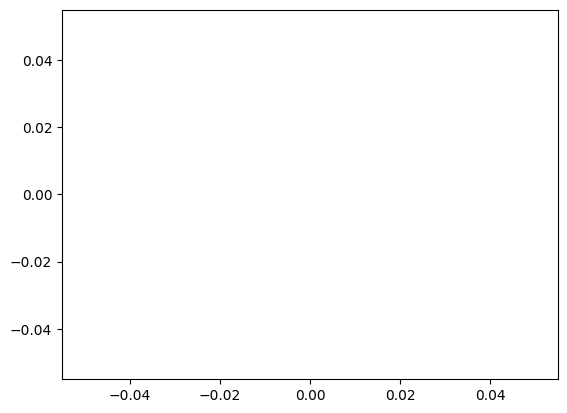

In [55]:
import matplotlib.pyplot as plt

plt.plot()

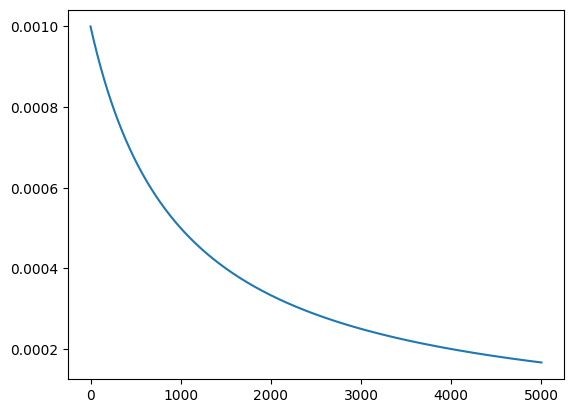

In [56]:
import numpy as np
step  = np.arange(0,100000)

lr_schedule(step)

plt.plot(step/20, lr_schedule(step))

In [57]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling




In [58]:
def callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(patience=200,  monitor="val_binary_crossentropy"),
        tf.keras.callbacks.TensorBoard(log_dir=tensorbaord_log_dir/name)
    ]

In [59]:
def fit_and_compile(model, name, epochs=10000, optimizer=None):
    if optimizer is None:
        optimizer = get_optimizer()
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = ["accuracy",  tf.keras.metrics.BinaryCrossentropy(from_logits=True, name="binary_crossentropy")]
    
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
    model.summary()
    
    map_fn = lambda x, y: (x, tf.expand_dims(y, axis=-1))

    
    history = model.fit(train_ds.map(map_fn),validation_data=validation_ds.map(map_fn),  epochs=epochs, callbacks=callbacks(name), verbose=0, steps_per_epoch = STEPS_PER_EPOCH,)
    return history

In [60]:
tiny_model = tf.keras.Sequential([
    tf.keras.Input(shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [61]:
model_histories = {}

In [62]:
model_histories["Tiny"] = fit_and_compile(model=tiny_model, name="Tiny")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4748,  binary_crossentropy:1.0959,  loss:1.0959,  val_accuracy:0.4590,  val_binary_crossentropy:0.9397,  val_loss:0.9397,  
...........

2025-05-27 10:06:17.093823: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/sachinmurali/anaconda3/envs/tensorflows/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-27 10:06:17.117201: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-27 10:06:17.154405: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-27 10:06:17.227230: I tensorflow/core/framework/local_re

.............

2025-05-27 10:06:17.365779: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


....................

2025-05-27 10:06:17.698860: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..............................

2025-05-27 10:06:18.239594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..........................
Epoch: 100, accuracy:0.6008,  binary_crossentropy:0.6228,  loss:0.6228,  val_accuracy:0.5610,  val_binary_crossentropy:0.6375,  val_loss:0.6375,  
........................................

2025-05-27 10:06:19.377766: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


............................................................
Epoch: 200, accuracy:0.6260,  binary_crossentropy:0.6091,  loss:0.6091,  val_accuracy:0.6160,  val_binary_crossentropy:0.6220,  val_loss:0.6220,  
..................................................................

2025-05-27 10:06:21.575373: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..................................
Epoch: 300, accuracy:0.6536,  binary_crossentropy:0.5942,  loss:0.5942,  val_accuracy:0.6280,  val_binary_crossentropy:0.6069,  val_loss:0.6069,  
....................................................................................................
Epoch: 400, accuracy:0.6638,  binary_crossentropy:0.5855,  loss:0.5855,  val_accuracy:0.6450,  val_binary_crossentropy:0.5970,  val_loss:0.5970,  
....................................................................................................
Epoch: 500, accuracy:0.6711,  binary_crossentropy:0.5807,  loss:0.5807,  val_accuracy:0.6570,  val_binary_crossentropy:0.5956,  val_loss:0.5956,  
.......................

2025-05-27 10:06:25.999043: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.............................................................................
Epoch: 600, accuracy:0.6778,  binary_crossentropy:0.5782,  loss:0.5782,  val_accuracy:0.6520,  val_binary_crossentropy:0.5965,  val_loss:0.5965,  
....................................................................................................
Epoch: 700, accuracy:0.6808,  binary_crossentropy:0.5751,  loss:0.5751,  val_accuracy:0.6630,  val_binary_crossentropy:0.5937,  val_loss:0.5937,  
....................................................................................................
Epoch: 800, accuracy:0.6840,  binary_crossentropy:0.5726,  loss:0.5726,  val_accuracy:0.6750,  val_binary_crossentropy:0.5924,  val_loss:0.5924,  
....................................................................................................
Epoch: 900, accuracy:0.6797,  binary_crossentropy:0.5706,  loss:0.5706,  val_accuracy:0.6800,  val_binary_crossentropy:0.5904,  val_loss:0.5904,  
...............................

2025-05-27 10:06:34.775180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


................................................................
Epoch: 1100, accuracy:0.6846,  binary_crossentropy:0.5675,  loss:0.5675,  val_accuracy:0.6700,  val_binary_crossentropy:0.5900,  val_loss:0.5900,  
....................................................................................................
Epoch: 1200, accuracy:0.6879,  binary_crossentropy:0.5662,  loss:0.5662,  val_accuracy:0.6700,  val_binary_crossentropy:0.5906,  val_loss:0.5906,  
....................................................................................................
Epoch: 1300, accuracy:0.6860,  binary_crossentropy:0.5649,  loss:0.5649,  val_accuracy:0.6750,  val_binary_crossentropy:0.5896,  val_loss:0.5896,  
....................................................................................................
Epoch: 1400, accuracy:0.6874,  binary_crossentropy:0.5641,  loss:0.5641,  val_accuracy:0.6740,  val_binary_crossentropy:0.5881,  val_loss:0.5881,  
........................................

2025-05-27 10:06:52.122565: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


..........................................
Epoch: 2100, accuracy:0.7031,  binary_crossentropy:0.5579,  loss:0.5579,  val_accuracy:0.6670,  val_binary_crossentropy:0.5850,  val_loss:0.5850,  
....................................................................................................
Epoch: 2200, accuracy:0.6985,  binary_crossentropy:0.5578,  loss:0.5578,  val_accuracy:0.6720,  val_binary_crossentropy:0.5848,  val_loss:0.5848,  
....................................................................................................
Epoch: 2300, accuracy:0.6960,  binary_crossentropy:0.5562,  loss:0.5562,  val_accuracy:0.6740,  val_binary_crossentropy:0.5817,  val_loss:0.5817,  
....................................................................................................
Epoch: 2400, accuracy:0.6999,  binary_crossentropy:0.5560,  loss:0.5560,  val_accuracy:0.6710,  val_binary_crossentropy:0.5834,  val_loss:0.5834,  
..............................................................

In [63]:
from tensorflow.keras import layers, regularizers

regularizer_histories = {}
regularizer_histories['Tiny'] = model_histories['Tiny']

l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = fit_and_compile(l2_model, "regularizers/l2")

/Users/sachinmurali/anaconda3/envs/tensorflows/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5028,  binary_crossentropy:0.8110,  loss:2.3365,  val_accuracy:0.5450,  val_binary_crossentropy:0.6757,  val_loss:2.1281,  
....................................................................................................
Epoch: 100, accuracy:0.6509,  binary_crossentropy:0.5997,  loss:0.6208,  val_accuracy:0.6500,  val_binary_crossentropy:0.5907,  val_loss:0.6118,  
....................................................................................................
Epoch: 200, accuracy:0.6703,  binary_crossentropy:0.5833,  loss:0.6056,  val_accuracy:0.6920,  val_binary_crossentropy:0.5790,  val_loss:0.6014,  
....................................................................................................
Epoch: 300, accuracy:0.6827,  binary_crossentropy:0.5718,  loss:0.5946,  val_accuracy:0.6620,  val_binary_crossentropy:0.5816,  val_loss:0.6046,  
....................................................................................................
Epoch: 40

In [64]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

NameError: name 'features' is not defined

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = fit_and_compile(dropout_model, "regularizers/dropout")

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = fit_and_compile(combined_model, "regularizers/combined")